Import necessary modules

In [1]:
import math
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from pyDOE import lhs
import time

Create data for learing and visualization

Default devise: cuda


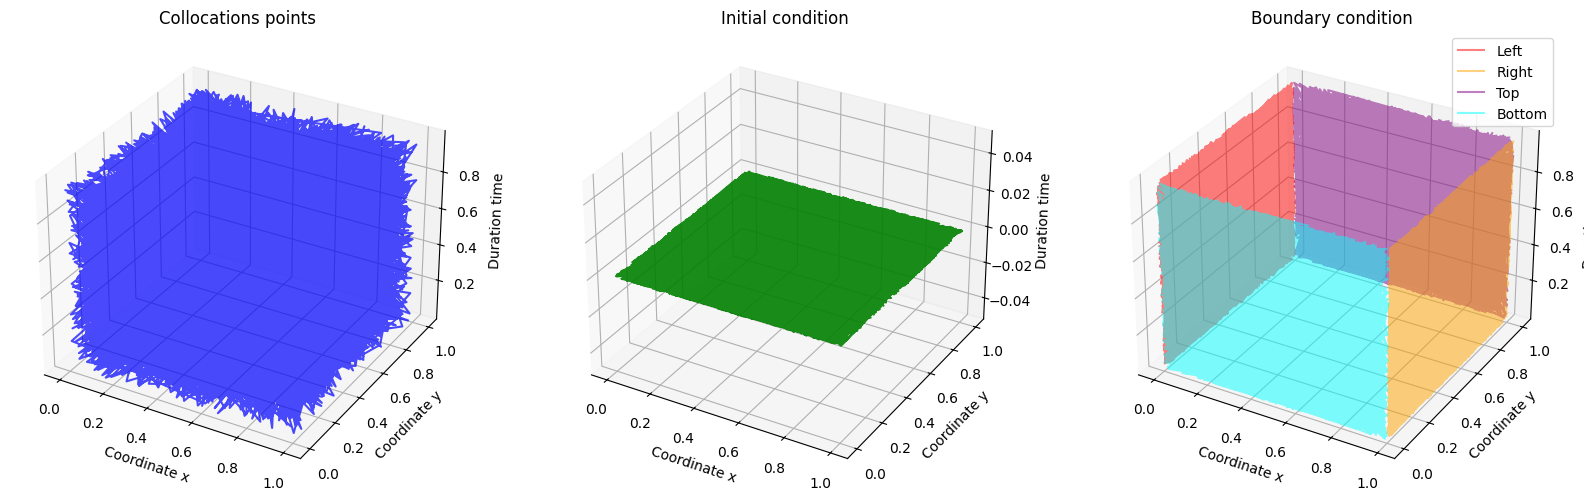

In [2]:
if torch.cuda.is_available():
    device = torch.device ("cuda")
else:
    device = torch.device ("cpu")

alpha = 0.1
epochs = 100000
point_collocation = 20000
point_initial = 20000
point_boundary = point_collocation // 4

print (f"Default devise: {device}")

x_min = 0
x_max = 1
y_min = 0
y_max = 1
t_min = 0
t_max = 1

T_init = 273 / 400

T_left = 320 / 400
T_right = 320 / 400
T_top = 400 / 400
T_bottom = 273 / 400

T_max = 400

def create_data ():

    x_colloc = lhs (1, point_collocation) * [x_max] + [x_min]
    y_colloc = lhs (1, point_collocation) * [y_max] + [y_min]
    t_colloc = lhs (1, point_collocation) * [t_max] + [t_min]

    x_init = lhs (1, 10000) * [x_max] + [x_min]
    y_init = lhs (1, 10000) * [y_max] + [y_min]
    t_init = np.full_like (x_init, 0.0)
    temp_init = np.full_like (x_init, T_init)
    temp_init = torch.tensor (temp_init,dtype = torch.float32).to(device).requires_grad_(True)

    left_x = np.zeros ((point_boundary, 1))
    left_y = lhs (1, point_boundary) * [y_max] + [y_min]

    right_x = np.ones ((point_boundary, 1))
    right_y = lhs (1, point_boundary) * [y_max] + [y_min]

    top_x = lhs (1, point_boundary) * [x_max] + [x_min]
    top_y = np.ones ((point_boundary, 1))

    bottom_x = lhs (1, point_boundary) * [x_max] + [x_min]
    bottom_y = np.zeros ((point_boundary, 1))

    time_bd = lhs (1, point_collocation) * [t_max] + [t_min]
    time_bd = torch.tensor (time_bd, dtype=torch.float32).to(device).requires_grad_ (True)

    temp_left = np.full_like (left_x, T_left)
    temp_right = np.full_like (right_x, T_right)
    temp_top = np.full_like (top_x, T_top)
    temp_bottom = np.full_like (bottom_x, T_bottom)

    x_colloc = torch.tensor (x_colloc, dtype=torch.float32).to(device).requires_grad_(True)
    y_colloc = torch.tensor (y_colloc, dtype=torch.float32).to(device).requires_grad_(True)
    t_colloc = torch.tensor (t_colloc, dtype=torch.float32).to(device).requires_grad_(True)

    x_init = torch.tensor (x_init, dtype=torch.float32).to(device).requires_grad_(True)
    y_init = torch.tensor (y_init, dtype=torch.float32).to(device).requires_grad_(True)
    t_init = torch.tensor (t_init, dtype=torch.float32).to(device).requires_grad_(True)

    x_bd = np.concatenate ((left_x, right_x, top_x, bottom_x), axis = 0)
    x_bd = torch.tensor (x_bd, dtype=torch.float32).to(device).requires_grad_(True)

    y_bd = np.concatenate ((left_y, right_y, top_y, bottom_y), axis = 0)
    y_bd = torch.tensor (y_bd, dtype=torch.float32).to(device).requires_grad_(True)

    temp_bd = np.concatenate ((temp_left, temp_right, temp_top, temp_bottom), axis = 0)
    temp_bd = torch.tensor (temp_bd, dtype=torch.float32).to(device).requires_grad_(True)




    return x_colloc, y_colloc, t_colloc, x_init, y_init, t_init, temp_init, left_x, left_y, right_x, right_y, top_x, top_y, bottom_x, bottom_y, x_bd, y_bd, time_bd, temp_bd

x_rod, y_rod, t_rod, x_init, y_init, t_init, temp_init, left_x, left_y, right_x, right_y, top_x, top_y, bottom_x, bottom_y, x_bd, y_bd, time_bd, temp_bd = create_data ()


figure = plt.figure (figsize= (20, 10))
axs_1 = figure.add_subplot (131,projection='3d')
axs_1.plot_wireframe (x_rod.cpu().detach().numpy(), y_rod.cpu().detach().numpy(), t_rod.cpu().detach().numpy(), color = 'blue', alpha=0.7)
axs_1.set_xlabel ("Coordinate x")
axs_1.set_ylabel ("Coordinate y")
axs_1.set_zlabel ("Duration time")
axs_1.set_title ("Collocations points")


axs_2 = figure.add_subplot (132, projection='3d')
axs_2.plot_wireframe (x_init.cpu().detach().numpy(), y_init.cpu().detach().numpy(), t_init.cpu().detach().numpy(), color = 'green', alpha = 0.9)
axs_2.set_xlabel ("Coordinate x")
axs_2.set_ylabel ("Coordinate y")
axs_2.set_zlabel ("Duration time")
axs_2.set_title ("Initial condition")

time_bd_for_graph = time_bd[:point_boundary].cpu ().detach().numpy()

axs_3 = figure.add_subplot (133, projection= '3d')
axs_3.plot_wireframe(left_x, left_y, time_bd_for_graph, color='red', alpha=0.5, label='Left')
axs_3.plot_wireframe(right_x, right_y, time_bd_for_graph, color='orange', alpha=0.5, label='Right')
axs_3.plot_wireframe(top_x, top_y, time_bd_for_graph, color='purple', alpha=0.5, label='Top')
axs_3.plot_wireframe(bottom_x, bottom_y, time_bd_for_graph, color='cyan', alpha=0.5, label='Bottom')
axs_3.set_xlabel ("Coordinate x")
axs_3.set_ylabel ("Coordinate y")
axs_3.set_zlabel ("Duration time")
axs_3.set_title ("Boundary condition")
axs_3.legend()

plt.show ()

Initializate model

In [3]:
def init_weight(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight.data)
        torch.nn.init.zeros_(m.bias.data)

In [4]:
class PINN (nn.Module):
    def __init__ (self, n_hidden, n_neurons, activation, verbose = True):
        super().__init__ ()
        self.model = nn.Sequential ()
        self.build_NN (n_hidden, n_neurons, activation)
        self.model.to(device)
        
        self.pde_loss_value = []
        self.init_loss_value = []
        self.bd_loss_value = []
        self.total_loss_value = []
        self.iteration = 0
        if verbose:
            print (self.model)

        self.model.apply (init_weight)
        self.adam = torch.optim.Adam(self.model.parameters() ,lr = 1e-3)


    def build_NN (self,n_hidden, n_neurons, activation):
        self.model.add_module ('input layer',nn.Linear (3, n_neurons))
        self.model.add_module ('activation func', activation)
        
        for _ in range (n_hidden-1):
            self.model.add_module (f'hidden layer number: {_}', nn.Linear (n_neurons, n_neurons))
            self.model.add_module (f'activation func {_}', activation)
        
        self.model.add_module ('Output layer',nn.Linear (n_neurons, 1))
    

    def forward (self, x, y, t):
        x = torch.concat ([x,y,t], dim=1).to(device)
        out = self.model (x)
        return out
    
    def predict (self, x, y, t):
        income = torch.concat ([x, y, t], dim=1).to(device)
        out = self.model (income)
        return out


    def closure (self):
        
        self.adam.zero_grad ()

        pde_loss = self.pde_loss (x_rod, y_rod, t_rod)
        init_loss = self.initial_loss (x_init, y_init, t_init)
        bd_loss = self.boundary_loss (x_bd, y_bd, time_bd)

        total_loss = pde_loss + init_loss * 100 + bd_loss * 10

        total_loss.backward ()
        
        self.pde_loss_value.append (pde_loss.item ())
        self.init_loss_value.append (init_loss.item ())
        self.bd_loss_value.append (bd_loss.item ())
        self.total_loss_value.append (total_loss.item ())
        if self.iteration % 100 == 1:
            print (f'total loss: {total_loss}')
        if self.iteration % 1000 == 1:
            print (f'Total loss : {total_loss}')
            print (f'Boundary loss: {bd_loss}')
            print (f'Initial loss: {init_loss}')
            print (f'PDe loss: {pde_loss}')
        self.iteration += 1
        return total_loss


    def pde_loss(model, x, y, t):
        u = model(x, y, t)
        u_t = torch.autograd.grad(u, t, create_graph=True, grad_outputs=torch.ones_like(t_rod))[0]
        u_x = torch.autograd.grad(u, x, create_graph=True, grad_outputs=torch.ones_like(x_rod))[0]
        u_xx = torch.autograd.grad(u_x, x, create_graph=True, grad_outputs=torch.ones_like(x_rod))[0]
        u_y = torch.autograd.grad(u, y, create_graph=True, grad_outputs=torch.ones_like(y_rod))[0]
        u_yy = torch.autograd.grad(u_y, y, create_graph=True, grad_outputs=torch.ones_like(y_rod))[0]

        physics_loss = u_t - (alpha)* (u_xx + u_yy)
        physics_loss = torch.mean(physics_loss**2)

        return physics_loss

    def boundary_loss(model, x, y, t):

        u = model(x, y ,t)
        loss = torch.mean(torch.square(u - temp_bd))

        return loss

    def initial_loss(model, x, y, t):

        u = model(x, y, t)
        loss = torch.mean(torch.square(u - temp_init))
        return loss

Training model

In [5]:
model = PINN(7, 50, nn.Tanh())
iteration_counter = 0
start_time = time.time ()
for epoch in range(epochs):
    
    model.closure ()
    model.adam.step ()
    if epoch % 100 == 0:
        print (iteration_counter)
    iteration_counter += 1
end_time = time.time ()

print (f"Trainig taking {end_time-start_time} second")

Sequential(
  (input layer): Linear(in_features=3, out_features=50, bias=True)
  (activation func): Tanh()
  (hidden layer number: 0): Linear(in_features=50, out_features=50, bias=True)
  (activation func 0): Tanh()
  (hidden layer number: 1): Linear(in_features=50, out_features=50, bias=True)
  (activation func 1): Tanh()
  (hidden layer number: 2): Linear(in_features=50, out_features=50, bias=True)
  (activation func 2): Tanh()
  (hidden layer number: 3): Linear(in_features=50, out_features=50, bias=True)
  (activation func 3): Tanh()
  (hidden layer number: 4): Linear(in_features=50, out_features=50, bias=True)
  (activation func 4): Tanh()
  (hidden layer number: 5): Linear(in_features=50, out_features=50, bias=True)
  (activation func 5): Tanh()
  (Output layer): Linear(in_features=50, out_features=1, bias=True)
)


C:\Users\Артем\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\autograd\graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


0
total loss: 27.073026657104492
Total loss : 27.073026657104492
Boundary loss: 0.5000676512718201
Initial loss: 0.22046281397342682
PDe loss: 0.026067528873682022
100
total loss: 0.2570752501487732
200
total loss: 0.2077530324459076
300
total loss: 0.16916386783123016
400
total loss: 0.1366041600704193
500
total loss: 0.122704416513443
600
total loss: 0.11900916695594788
700
total loss: 0.11615265905857086
800
total loss: 0.11349780857563019
900
total loss: 0.110801100730896
1000
total loss: 0.10772230476140976
Total loss : 0.10772230476140976
Boundary loss: 0.007308799773454666
Initial loss: 7.638328679604456e-05
PDe loss: 0.026995977386832237
1100
total loss: 0.10383902490139008
1200
total loss: 0.09936483204364777
1300
total loss: 0.09829645603895187
1400
total loss: 0.09463611245155334
1500
total loss: 0.09221544861793518
1600
total loss: 0.09278750419616699
1700
total loss: 0.0901605561375618
1800
total loss: 0.08796342462301254
1900
total loss: 0.08575642108917236
2000
total los

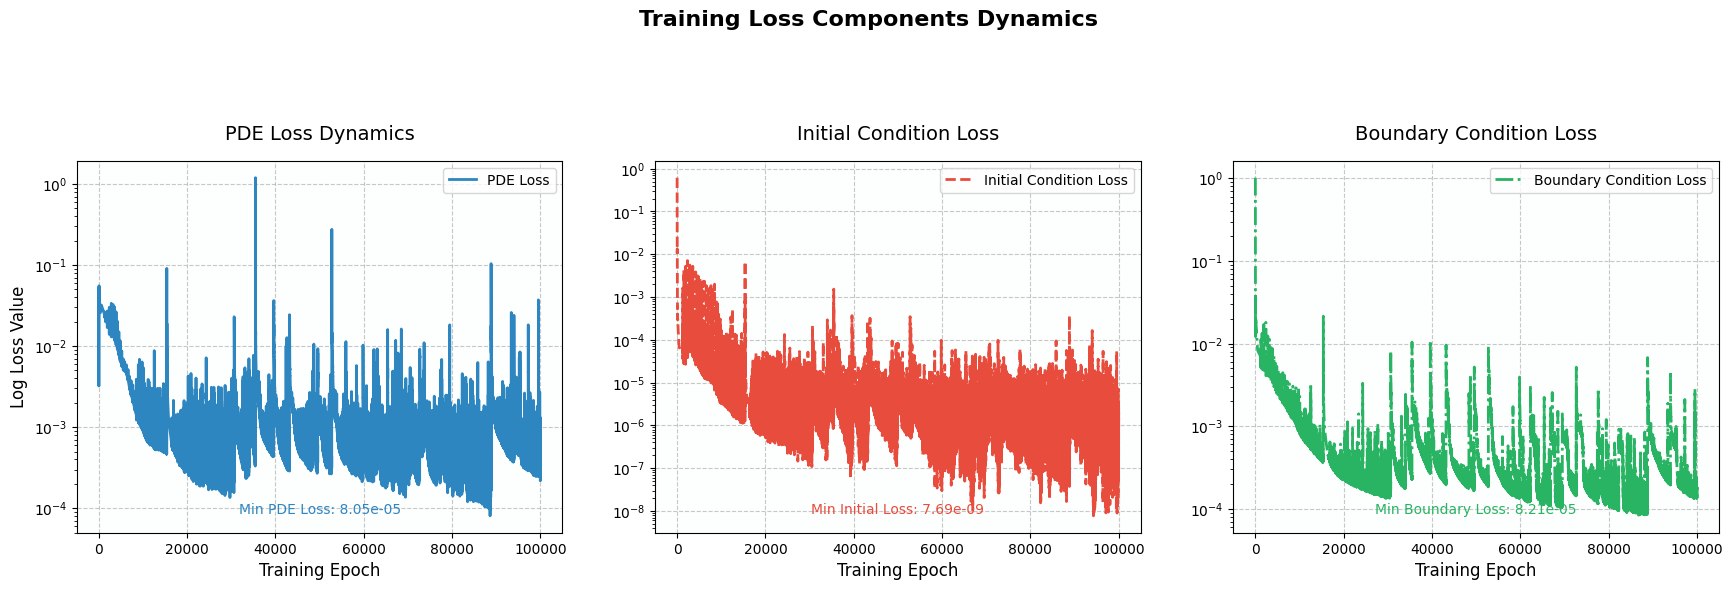

In [6]:
epoch_for_graph = np.linspace (0, epoch+2, epoch+1)

# Стиль и цветовая палитра
# plt.style.use('seaborn-darkgrid')
colors = ['#2E86C1', '#E74C3C', '#28B463']

# Создание фигуры с тремя сабплотами
fig, axs = plt.subplots(1, 3, figsize=(18, 6), dpi=100)

# Общие настройки для всех графиков
for ax in axs:
    ax.set_facecolor('#FDFEFE')  # Цвет фона
    ax.grid(True, linestyle='--', alpha=0.7)  # Стиль сетки
    ax.tick_params(axis='both', which='major', labelsize=10)


axs[0].semilogy(epoch_for_graph, model.pde_loss_value, 
               color=colors[0], 
               linewidth=2,
               label='PDE Loss')
axs[0].set_title('PDE Loss Dynamics', fontsize=14, pad=15)
axs[0].set_xlabel('Training Epoch', fontsize=12)
axs[0].set_ylabel('Log Loss Value', fontsize=12)
axs[0].legend(fontsize=10, frameon=True)

# График Initial Loss
axs[1].semilogy(epoch_for_graph, model.init_loss_value, 
               color=colors[1], 
               linewidth=2,
               linestyle='--',
               label='Initial Condition Loss')
axs[1].set_title('Initial Condition Loss', fontsize=14, pad=15)
axs[1].set_xlabel('Training Epoch', fontsize=12)
axs[1].legend(fontsize=10, frameon=True)

# График Boundary Loss
axs[2].semilogy(epoch_for_graph, model.bd_loss_value, 
               color=colors[2], 
               linewidth=2,
               linestyle='-.',
               label='Boundary Condition Loss')
axs[2].set_title('Boundary Condition Loss', fontsize=14, pad=15)
axs[2].set_xlabel('Training Epoch', fontsize=12)
axs[2].legend(fontsize=10, frameon=True)


plt.suptitle('Training Loss Components Dynamics', 
            fontsize=16, 
            y=1.02,
            fontweight='bold')
plt.tight_layout(pad=3.0)


for i, (loss, label) in enumerate(zip([model.pde_loss_value, 
                                     model.init_loss_value, 
                                     model.bd_loss_value], 
                                    ['PDE', 'Initial', 'Boundary'])):
    min_loss = min(loss)
    axs[i].annotate(f'Min {label} Loss: {min_loss:.2e}',
                   xy=(0.5, 0.05),
                   xycoords='axes fraction',
                   ha='center',
                   fontsize=10,
                   color=colors[i])

plt.show()

In [7]:
import imageio
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

def create_custom_gif_random(model, time_points, output_dir="temperature_adam_default_initi_random", filename="temperature_gif_adam_init_default_random.gif"):
    # Создаем директорию для сохранения графиков, если она не существует
    os.makedirs(output_dir, exist_ok=True)
    
    # Создаем регулярную сетку для интерполяции
    grid_x, grid_y = np.mgrid[0:1:100j, 0:1:100j]
    
    frames = []
    model.eval()  # Переводим модель в режим оценки
    
    for idx, time in enumerate(time_points):
        with torch.no_grad():
            # Генерируем случайные координаты (можно заменить на ваши x_rod, y_rod)
            x = torch.rand(10000, 1)
            y = torch.rand(10000, 1)
            t = torch.full_like(x, time)
            
            # Получаем предсказания модели
            u_value = model(x, y, t).cpu().numpy() * T_max
            
            # Преобразуем тензоры в numpy массивы
            x_np = x.numpy().flatten()
            y_np = y.numpy().flatten()
            u_np = u_value.flatten()
            
            # Интерполируем на регулярную сетку
            grid_u = griddata((x_np, y_np), u_np, (grid_x, grid_y), method='cubic')
            
            # Создаем график
            fig = plt.figure(figsize=(8, 6))
            plt.contourf(grid_x, grid_y, grid_u, levels=50, cmap='hot')
            plt.colorbar(label='Temperature (K)')
            plt.title(f'Temperature Distribution at t={time:.2f}')
            plt.xlabel('X coordinate')
            plt.ylabel('Y coordinate')
            
            # Сохраняем график в файл
            frame_filename = os.path.join(output_dir, f"temperature_frame_{idx:03d}.png")
            plt.savefig(frame_filename)
            plt.close(fig)  # Закрываем фигуру после сохранения
            
            # Сохраняем кадр в памяти для GIF
            fig = plt.figure(figsize=(8, 6))
            plt.contourf(grid_x, grid_y, grid_u, levels=50, cmap='hot')
            plt.colorbar(label='Temperature (K)')
            plt.title(f'Temperature Distribution at t={time:.2f}')
            plt.xlabel('X coordinate')
            plt.ylabel('Y coordinate')
            fig.canvas.draw()
            frame = np.array(fig.canvas.renderer.buffer_rgba())
            frames.append(frame)
            plt.close(fig)
    
    # Сохраняем анимацию
    imageio.mimsave(filename, frames, fps=2, loop=0)
    print(f"GIF успешно сохранен как {filename}")

# Пример использования
if __name__ == "__main__":
    # Параметры анимации
    time_points = torch.linspace(0, 1, 20)  # 20 кадров
    
    # Создаем GIF
    create_custom_gif_random(model, time_points)
    
    # Для Google Colab раскомментируйте следующую строку:
    # files.download("temperature_animation.gif")

GIF успешно сохранен как temperature_gif_adam_init_default_random.gif


In [8]:
import imageio
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

def create_custom_gif(model, time_points, output_dir="temperature_adam_default_init_rod_points", filename="temperature_gif_adam_init_default_rod.gif"):
    # Создаем директорию для сохранения графиков, если она не существует
    os.makedirs(output_dir, exist_ok=True)
    
    # Создаем регулярную сетку для интерполяции
    grid_x, grid_y = np.mgrid[0:1:100j, 0:1:100j]
    
    frames = []
    model.eval()  # Переводим модель в режим оценки
    
    for idx, time in enumerate(time_points):
        with torch.no_grad():
            # Генерируем случайные координаты (можно заменить на ваши x_rod, y_rod)
            x = x_rod
            y = y_rod
            t = torch.full_like(x, time)
            
            # Получаем предсказания модели
            u_value = model(x, y, t).cpu().numpy() * T_max
            
            # Преобразуем тензоры в numpy массивы
            x_np = x.cpu().numpy().flatten()
            y_np = y.cpu().numpy().flatten()
            u_np = u_value.flatten()
            
            # Интерполируем на регулярную сетку
            grid_u = griddata((x_np, y_np), u_np, (grid_x, grid_y), method='cubic')
            
            # Создаем график
            fig = plt.figure(figsize=(8, 6))
            plt.contourf(grid_x, grid_y, grid_u, levels=50, cmap='hot')
            plt.colorbar(label='Temperature (K)')
            plt.title(f'Temperature Distribution at t={time:.2f}')
            plt.xlabel('X coordinate')
            plt.ylabel('Y coordinate')
            
            # Сохраняем график в файл
            frame_filename = os.path.join(output_dir, f"temperature_frame_{idx:03d}.png")
            plt.savefig(frame_filename)
            plt.close(fig)  # Закрываем фигуру после сохранения
            
            # Сохраняем кадр в памяти для GIF
            fig = plt.figure(figsize=(8, 6))
            plt.contourf(grid_x, grid_y, grid_u, levels=50, cmap='hot')
            plt.colorbar(label='Temperature (K)')
            plt.title(f'Temperature Distribution at t={time:.2f}')
            plt.xlabel('X coordinate')
            plt.ylabel('Y coordinate')
            fig.canvas.draw()
            frame = np.array(fig.canvas.renderer.buffer_rgba())
            frames.append(frame)
            plt.close(fig)
    
    # Сохраняем анимацию
    imageio.mimsave(filename, frames, fps=2, loop=0)
    print(f"GIF успешно сохранен как {filename}")

# Пример использования
if __name__ == "__main__":
    # Параметры анимации
    time_points = torch.linspace(0, 1, 20)  # 20 кадров
    
    # Создаем GIF
    create_custom_gif(model, time_points)
    
    # Для Google Colab раскомментируйте следующую строку:
    # files.download("temperature_animation.gif")

GIF успешно сохранен как temperature_gif_adam_init_default_rod.gif
